In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
PREPARED_BASE_PATH = "../data_lake/prepared/interactions"

def get_latest_prepared_file():
    all_files = []
    for root, dirs, files in os.walk(PREPARED_BASE_PATH):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))

    if not all_files:
        raise Exception("No prepared interaction files found.")

    return max(all_files, key=os.path.getmtime)

file_path = get_latest_prepared_file()
print("Using prepared dataset:", file_path)

df = pd.read_csv(file_path)
df.head()


Using prepared dataset: ../data_lake/prepared/interactions\2026\01\21\interactions_prepared_20260121_144731.csv


,user_id,item_id,event_type,rating,timestamp,device,session_id
0,U0038,P0002,click,NaN,2026-01-19 15:50:54.003126,mobile,S3705
1,U0010,P0029,rating,4.0,2026-01-19 05:12:45.003126,mobile,S9332
2,U0028,P0011,purchase,NaN,2026-01-19 11:23:13.003126,web,S2355
3,U0045,P0002,purchase,NaN,2026-01-19 12:07:57.003126,web,S9717
4,U0014,P0023,view,NaN,2026-01-19 06:39:50.003126,mobile,S4570


In [3]:
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     1000 non-null   object 
 1   item_id     1000 non-null   object 
 2   event_type  1000 non-null   object 
 3   rating      238 non-null    float64
 4   timestamp   1000 non-null   object 
 5   device      1000 non-null   object 
 6   session_id  1000 non-null   object 
dtypes: float64(1), object(6)
memory usage: 54.8+ KB


,user_id,item_id,event_type,rating,timestamp,device,session_id
count,1000,1000,1000,238.000000,1000,1000,1000
unique,50,30,4,NaN,991,2,938
top,U0028,P0011,rating,NaN,2026-01-19 05:52:18.003126,web,S6448
freq,31,42,261,NaN,2,509,3
mean,NaN,NaN,NaN,2.882353,NaN,NaN,NaN
std,NaN,NaN,NaN,1.438919,NaN,NaN,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,2.000000,NaN,NaN,NaN
50%,NaN,NaN,NaN,3.000000,NaN,NaN,NaN
75%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN


Categorical attributes such as event type and device are encoded using one-hot encoding so that machine learning models can process them numerically.

In [4]:
# Encoding categorical columns: event_type, device
df_encoded = pd.get_dummies(df, columns=["event_type", "device"])
df_encoded.head()


,user_id,item_id,rating,timestamp,session_id,event_type_click,event_type_purchase,event_type_rating,event_type_view,device_mobile,device_web
0,U0038,P0002,NaN,2026-01-19 15:50:54.003126,S3705,True,False,False,False,True,False
1,U0010,P0029,4.0,2026-01-19 05:12:45.003126,S9332,False,False,True,False,True,False
2,U0028,P0011,NaN,2026-01-19 11:23:13.003126,S2355,False,True,False,False,False,True
3,U0045,P0002,NaN,2026-01-19 12:07:57.003126,S9717,False,True,False,False,False,True
4,U0014,P0023,NaN,2026-01-19 06:39:50.003126,S4570,False,False,False,True,True,False


Numerical variables are normalized using Min-Max scaling to bring all values into the [0,1] range.

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_encoded[["rating"]] = scaler.fit_transform(df_encoded[["rating"]].fillna(0))

df_encoded.head()


,user_id,item_id,rating,timestamp,session_id,event_type_click,event_type_purchase,event_type_rating,event_type_view,device_mobile,device_web
0,U0038,P0002,0.0,2026-01-19 15:50:54.003126,S3705,True,False,False,False,True,False
1,U0010,P0029,0.8,2026-01-19 05:12:45.003126,S9332,False,False,True,False,True,False
2,U0028,P0011,0.0,2026-01-19 11:23:13.003126,S2355,False,True,False,False,False,True
3,U0045,P0002,0.0,2026-01-19 12:07:57.003126,S9717,False,True,False,False,False,True
4,U0014,P0023,0.0,2026-01-19 06:39:50.003126,S4570,False,False,False,True,True,False


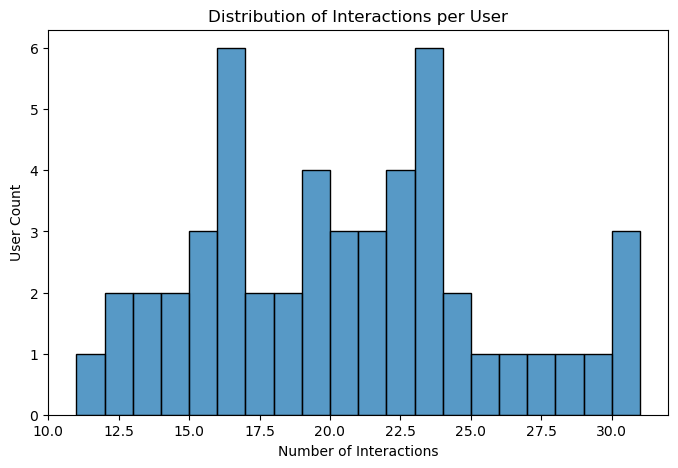

In [6]:
interactions_per_user = df["user_id"].value_counts()

plt.figure(figsize=(8,5))
sns.histplot(interactions_per_user, bins=20)
plt.title("Distribution of Interactions per User")
plt.xlabel("Number of Interactions")
plt.ylabel("User Count")
plt.show()


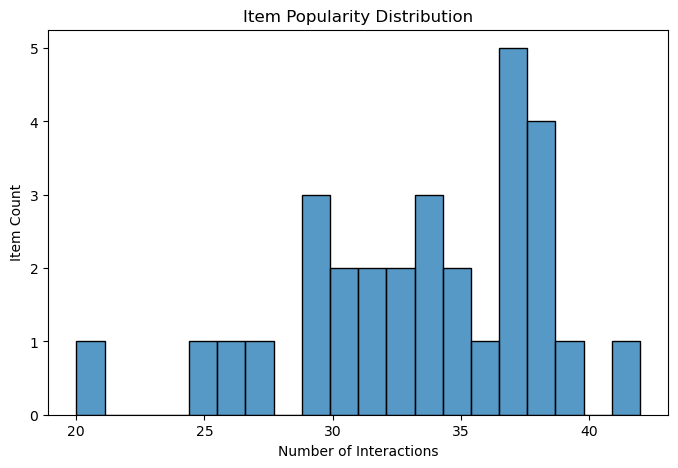

In [7]:
interactions_per_item = df["item_id"].value_counts()

plt.figure(figsize=(8,5))
sns.histplot(interactions_per_item, bins=20)
plt.title("Item Popularity Distribution")
plt.xlabel("Number of Interactions")
plt.ylabel("Item Count")
plt.show()


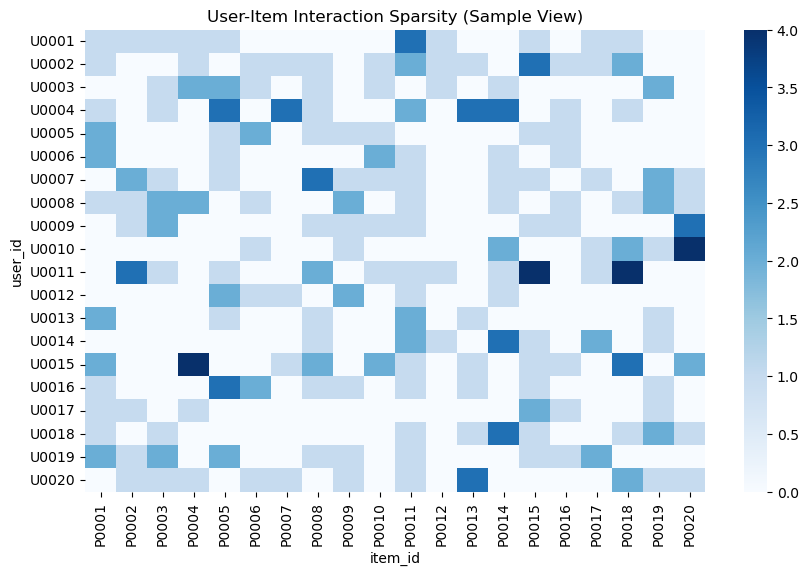

In [8]:
# Build user-item interaction matrix
user_item_matrix = pd.pivot_table(
    df,
    index="user_id",
    columns="item_id",
    values="event_type",
    aggfunc="count",
    fill_value=0
)

plt.figure(figsize=(10,6))
sns.heatmap(user_item_matrix.iloc[:20, :20], cmap="Blues")
plt.title("User-Item Interaction Sparsity (Sample View)")
plt.show()


In [9]:
OUTPUT_PATH = "../data_lake/prepared/interactions_for_features.csv"
df_encoded.to_csv(OUTPUT_PATH, index=False)
print("Encoded and normalized dataset saved to:", OUTPUT_PATH)


Encoded and normalized dataset saved to: ../data_lake/prepared/interactions_for_features.csv
